In [1]:
import pandas as pd
import tensorflow as tf
from PIL import Image
import os
import shutil
import random
import numpy as np
import json
from yattag import Doc, indent
import xml.etree.ElementTree as ET
from aug_tools.bbox_util import *
from aug_tools.data_aug import *
import copy
import importlib
%load_ext autoreload

2022-06-21 20:27:07.721538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 20:27:07.721575: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
base_folder = "no_resize_no_augmentation"
images = f"{base_folder}/images"
annotations = f"{base_folder}/annotations"

# Try to modify a dummy image

In [3]:
dummy_file = "audible__9"
dummy_bbox = ET.parse(f"{annotations}/{dummy_file}.xml")
dummy_img = cv2.imread(f"{images}/{dummy_file}.png", cv2.IMREAD_UNCHANGED)#[:,:,::-1] # cv2.COLOR_BGRA2RGBA # cv2.IMREAD_UNCHANGED # cv2.IMREAD_GRAYSCALE
# dummy_image = np.array(Image.open(f"{images}/{dummy_file}.png").convert('RGB'))

In [4]:
resize = Resize(640)


In [5]:
def bbox_array(xml_file):
  array = []
  for object in xml_file.getroot().findall('object'):
    array.append([float(coord.text) for coord in object.find('bndbox')])

  return np.array(array)

In [6]:
bboxes = bbox_array(dummy_bbox)

In [7]:
dummy_img.shape

(420, 1024, 4)

In [8]:
def add_background(alpha_image):
    # background = cv2.imread(f"{images}/worlds_of_warships__logo_10.png", cv2.IMREAD_UNCHANGED)[:dummy_img.shape[1], :dummy_img.shape[0]]
    # background = np.array(Image.open(f"random_bg.png"))[:alpha_image.shape[0], :alpha_image.shape[1]]
    bg_file = random.choice(os.listdir("backgrounds"))
    background = cv2.imread(f"backgrounds/{bg_file}", cv2.IMREAD_UNCHANGED) #[:dummy_img.shape[1], :dummy_img.shape[0]]
    background = cv2.cvtColor(background, cv2.COLOR_BGR2BGRA)
    background = cv2.resize(background, alpha_image.shape[-2::-1]) # [-2::-1]
    foreground = alpha_image

    # normalize alpha channels from 0-255 to 0-1
    alpha_background = background[:,:,3] / 255.0
    alpha_foreground = foreground[:,:,3] / 255.0

    # set adjusted colors
    for color in range(0, 3):
        background[:,:,color] = alpha_foreground * foreground[:,:,color] + \
            alpha_background * background[:,:,color] * (1 - alpha_foreground)

    # set adjusted alpha and denormalize back to 0-255
    background[:,:,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background)) * 255
    return background
    return cv2.cvtColor(background, cv2.COLOR_BGRA2BGR)

if dummy_img.shape[2] == 4:
    dummy_img = add_background(dummy_img)

In [9]:
dummy_img.shape

(420, 1024, 4)

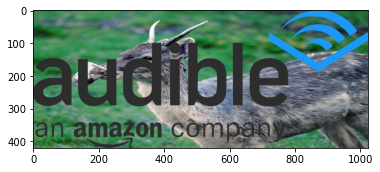

In [10]:
plt.imshow(dummy_img)

In [11]:
cv2.imwrite('yes.png', dummy_img)

True

In [12]:
# cv2.imshow('ntm', dummy_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

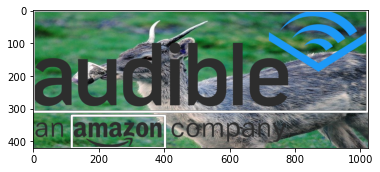

In [13]:
plotted_dummy_img = draw_rect(dummy_img, bboxes, color=[0,0,0])
plt.imshow(plotted_dummy_img)

In [14]:
random.randrange(20, 60)/100

0.32

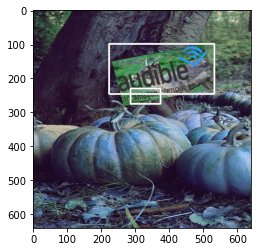

In [78]:

rand = random.randrange(30, 80)/100
seq = Sequence([Resize(640) ,RandomRotate(10), RandomShear(0.25), RandomScale((-0.7, -0.3)), RandomTranslate(0.35,diff=True), RandomHSV(15, 15, 8)])
#seq = Sequence([Resize(640) ,RandomRotate(10), RandomShear(0.25), RandomScale((-0.6, 0)), RandomHSV(15, 15, 8)])
img_, bboxes_ = seq(dummy_img.copy(), bboxes.copy())
img_ = add_background(img_)

plotted_img = draw_rect(img_, bboxes_, color=[100,100,100])
plt.imshow(plotted_img)

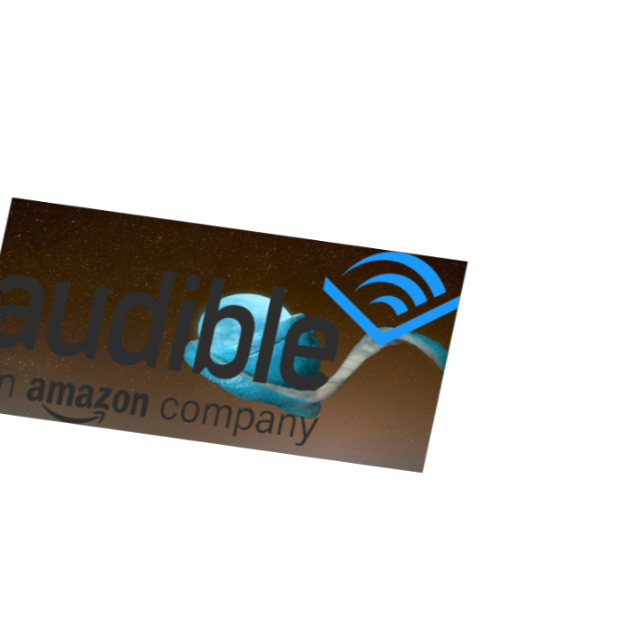

In [15]:
Image.fromarray(img_)

# Count the number of each class to know how many augmentation we need to do on each image

In [83]:
images_list = os.listdir(images)

In [84]:
images_list = [image_name.split('__')[0] for image_name in images_list]

In [85]:
images_count = {}
for image_name in images_list:
  images_count[image_name] = images_count.get(image_name, 0) + 1

In [86]:
for item, value in images_count.items():
  # print(f"{item} ({value}) With {round(250 / value)} images per image, we can get to {value * round(250 / value)} images")
  images_count[item] = round(250 / value)

# Data augmentation

In [87]:
def to_xml(xml_file, bboxes, shape, name=None):
    for bbox, xml_object in zip(bboxes, xml_file.findall('object')):
      for i in range(4):
        xml_object.find('bndbox')[i].text = str(int(bbox[i]))
      
      if name:
        xml_file.find('filename').text = new_name + ".png"
        
      xml_file.find('size')[0].text = str(shape[1])
      xml_file.find('size')[1].text = str(shape[0])

In [92]:
output_folder = "/media/obyzam/Bianca/dataset/640_data_augment"
output_images = f"{output_folder}/images"
output_annotations = f"{output_folder}/annotations"

In [94]:
all_images = []
os.mkdir(output_folder)
os.mkdir(output_images)
os.mkdir(output_annotations)
#os.chmod(output_folder,777)
resize = Resize(640)
count = 0
seq = Sequence([Resize(640) ,RandomRotate(10), RandomShear(0.25), RandomScale((-0.7, -0.3)), RandomTranslate(0.4,diff=True)])
for index, xml_name in enumerate(os.listdir(annotations)):
  if (xml_name == ".DS_Store"):
    continue

  # Load the xml
  xml_file = ET.parse(f"{annotations}/{xml_name}")
  label = xml_name.split('__')[0]
  base_bboxes = bbox_array(xml_file)

  # Load the image
  img_name = xml_file.getroot().find('filename').text
  img_name_root = img_name.split('.')[0]
  # base_img = cv2.imread(f"{images}/{img_name}", cv2.COLOR_BGR2RGB) #[:,:,::-1] # tester import classique
  base_img = cv2.imread(f"{images}/{img_name}", cv2.IMREAD_UNCHANGED)

  # Add a background if it's a transparent png
  # if base_img.shape[2] == 4:
  #   base_img = add_background(base_img)
  # else:
  #   print('not common shape', img_name)
  #   base_img = cv2.cvtColor(base_img, cv2.COLOR_RGB2BGR)

  # Resize the image and modify the xml
  resized_img, resized_bboxes = resize(base_img, base_bboxes)
  to_xml(xml_file, resized_bboxes, resized_img.shape)

  # Save the base image and xml
  cv2.imwrite(f"{output_images}/{img_name}", add_background(resized_img))
  xml_file.write(f"{output_annotations}/{xml_name}")


  for iteration in range(images_count[label]):
    new_file = copy.deepcopy(xml_file) # Est-ce que ça copie celui de base ou le modifié

    # Apply the modification to the copies
    img_, bboxes_ = seq(resized_img.copy(), resized_bboxes.copy())

    # Modify the xml for the bounding boxes, filename and new size
    new_name = f"{img_name_root}_{iteration}"
    to_xml(new_file, bboxes_, img_.shape, new_name)

    # Adding a backgroud to the image
    img_ = add_background(img_)

    # slightly altering the colors
    img_,bboxes_ = RandomHSV(15, 15, 8)(img_,bboxes_)

    # Save the image and xml
    cv2.imwrite(f"{output_images}/{new_name}.png", img_)
    new_file.write(f"{output_annotations}/{new_name}.xml")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc